#Importing Dependencies

In [25]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import models
import matplotlib.pyplot as plt
%matplotlib inline

#Initializing the Data

Transforming dataset to tensors..

In [26]:
dataset_path = "/content/drive/MyDrive/PlantVillage"

In [27]:
dataset = ImageFolder(dataset_path, tt.Compose([tt.Resize((224,224)),
                                              tt.RandomHorizontalFlip(0.5),
                                              tt.ToTensor()]))

Classes that dataset contains..

In [28]:
class_names = dataset.classes
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

Spliting dataset into Train, Validation and Test set...

In [29]:
val_size = 215
test_size = 215
train_size = len(dataset) - test_size
train2_size = train_size - val_size

train_ds, test_ds = random_split(dataset, [train_size, test_size])
train_ds, val_ds = random_split(train_ds, [train2_size, val_size])

In [30]:
len(dataset), len(train_ds), len(test_ds), len(val_ds)

(2152, 1722, 215, 215)

Creating DataLoaders to run in Batches...

In [31]:
batch_size = 128
train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, shuffle=False, batch_size=batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Examples from the training data...

In [32]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=12).permute(1, 2, 0))
        break

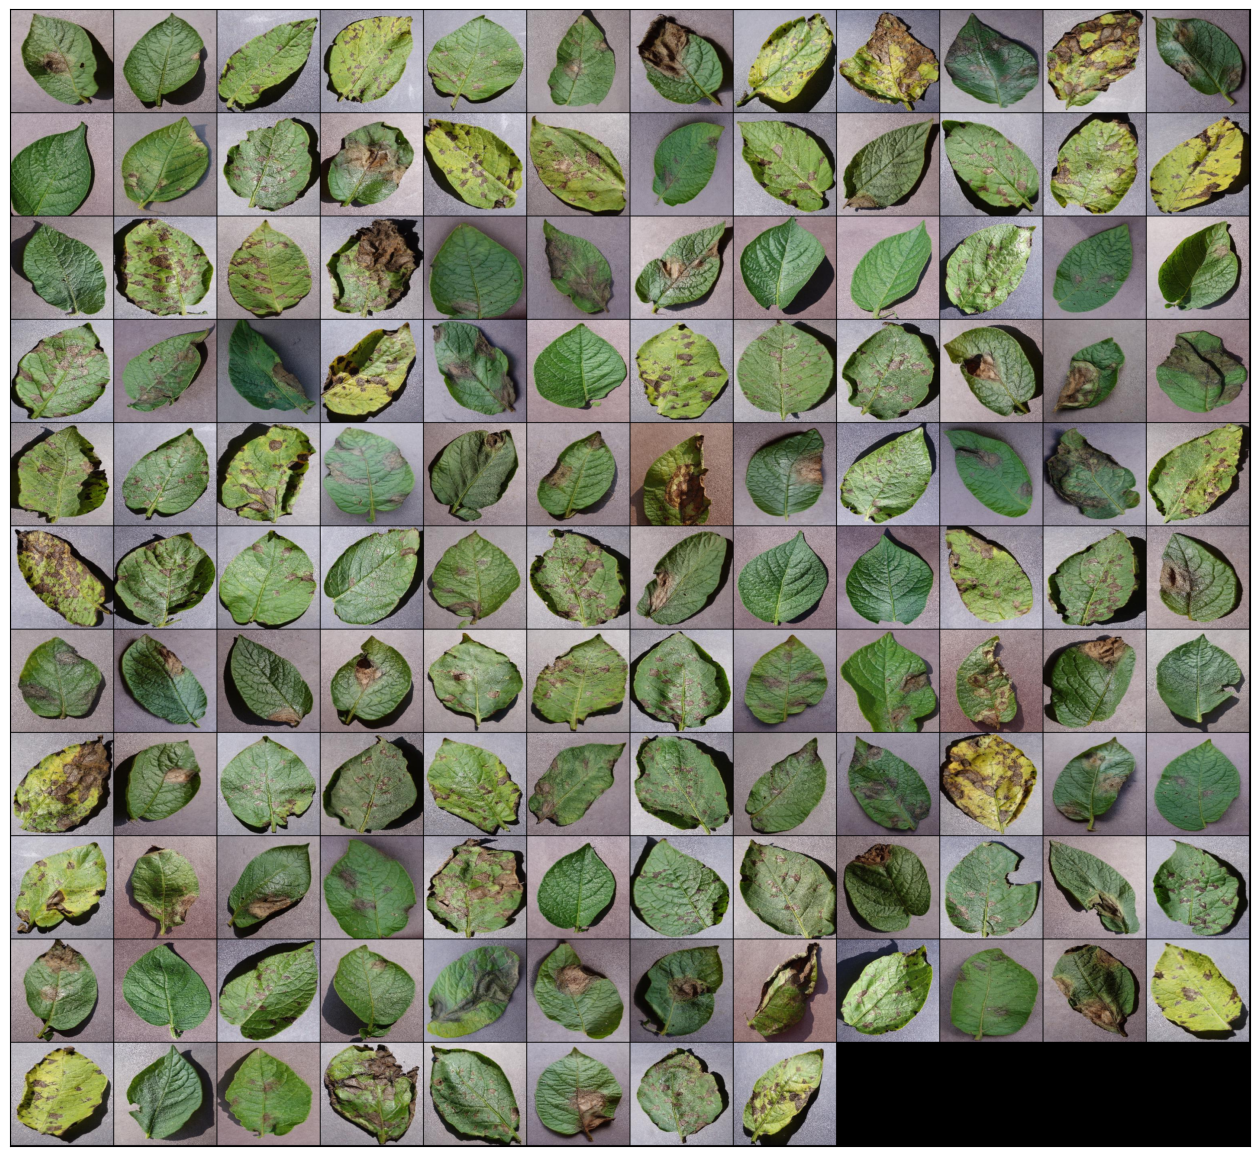

In [33]:
show_batch(train_dl)

#Model

Designing the Base Class i.e the training steps

In [34]:
from torch.nn.modules import loss
class Base(nn.Module):
  def training_step(self, batch):
   inputs, targets = batch
   preds = self(inputs)    #Making Predictions from the images in training set...
   loss = F.cross_entropy(preds, targets) #Calculating the Loss
   return loss

  def validation_step(self, batch):
   inputs, targets = batch
   preds = self(inputs)      #Making Predictions from the images in validation set..
   loss = F.cross_entropy(preds, targets)  #Calculating the loss
   acc = accuracy(preds, targets)    #Calculating the accuracy
   return {'val_loss': loss.detach(), 'val_acc': acc}

  def val_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses #taking avg
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies #taking avg
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
     print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


def accuracy(outputs, targets):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == targets).item() / len(preds))

Designing the Convolution Neural Network for out Model derived from the base class..

In [35]:
class PotatoDisease(Base):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(

        nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.AdaptiveMaxPool2d(1),

        nn.Flatten(),
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Linear(64, 3)
        )

  def forward(self, x):
    return self.network(x)

In [36]:
model = PotatoDisease()
model

PotatoDisease(
  (network): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): AdaptiveMaxPool2d(output_size=1)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=32, out_features=64, bias=True)
    (15): ReLU()
    (16): Linear(in_features=64, out_features=3, bias=True)
  )
)

#Training

Defining Training steps for the model..

In [37]:
@torch.no_grad()
def evaluate(model, val_dl):   #Function for Evaluating model accuracy and loss on specific dataset(train, test, validation)
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.val_epoch_end(outputs)

def run(epochs, lr, model, train_dl, val_dl, opt_func):
  record=[]
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    #Training Process
    model.train()
    train_losses = []
    for batch in train_dl:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    #Validation Process
    result = evaluate(model, val_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    record.append(result)
  return record

In [38]:
evaluate(model, val_dl) # Checking accuracy and loss of the model for validation set...

{'val_loss': 1.044951319694519, 'val_acc': 0.4651162922382355}

Training the model to get precise and accurate predictions...

In [39]:
num_epochs = 10
lr = 0.001
opt_func = torch.optim.Adam

In [41]:
%%time
history = run(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.5832, val_loss: 0.5635, val_acc: 0.7907
Epoch [1], train_loss: 0.5477, val_loss: 0.5198, val_acc: 0.8419
Epoch [2], train_loss: 0.5268, val_loss: 0.5263, val_acc: 0.8279
Epoch [3], train_loss: 0.5001, val_loss: 0.4807, val_acc: 0.8605
Epoch [4], train_loss: 0.4944, val_loss: 0.4781, val_acc: 0.8558
Epoch [5], train_loss: 0.4787, val_loss: 0.4749, val_acc: 0.8512
Epoch [6], train_loss: 0.4896, val_loss: 0.4833, val_acc: 0.8419
Epoch [7], train_loss: 0.4719, val_loss: 0.4637, val_acc: 0.8605
Epoch [8], train_loss: 0.4578, val_loss: 0.4676, val_acc: 0.8465
Epoch [9], train_loss: 0.4572, val_loss: 0.4774, val_acc: 0.8465
CPU times: user 3min 6s, sys: 1min 38s, total: 4min 45s
Wall time: 5min 35s


#Visualization

Loss Graph

In [42]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

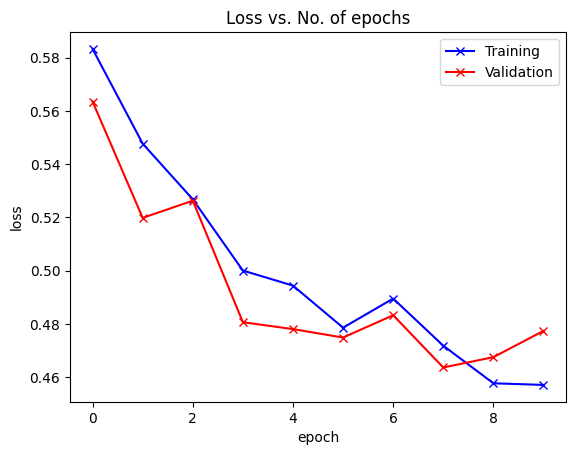

In [43]:
plot_losses(history)

Accuracy Graph

In [44]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

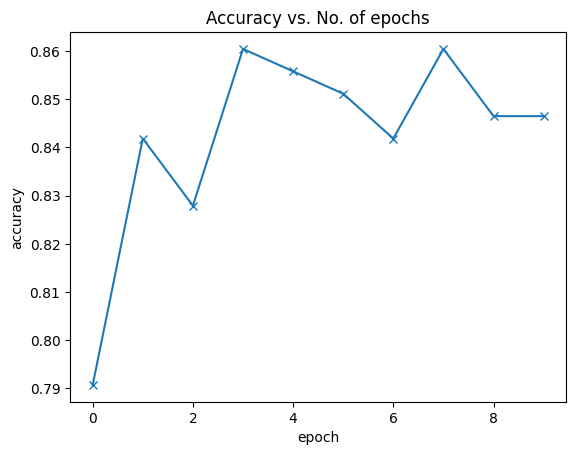

In [45]:
plot_accuracies(history)

#Prediction

In [46]:
evaluate(model, test_dl) #Checking the model loss and accuracy for the test set..

{'val_loss': 0.5347757935523987, 'val_acc': 0.8204920887947083}

Testing the model's accuracy on Test Data by predicting some images..

In [47]:
def predict_image(img, model):
    # Converting to a batch of 1
    xb = img.unsqueeze(0)
    # Getting predictions from the model
    yb = model(xb)
    # Picking the index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieving the class label
    return dataset.classes[preds[0].item()]

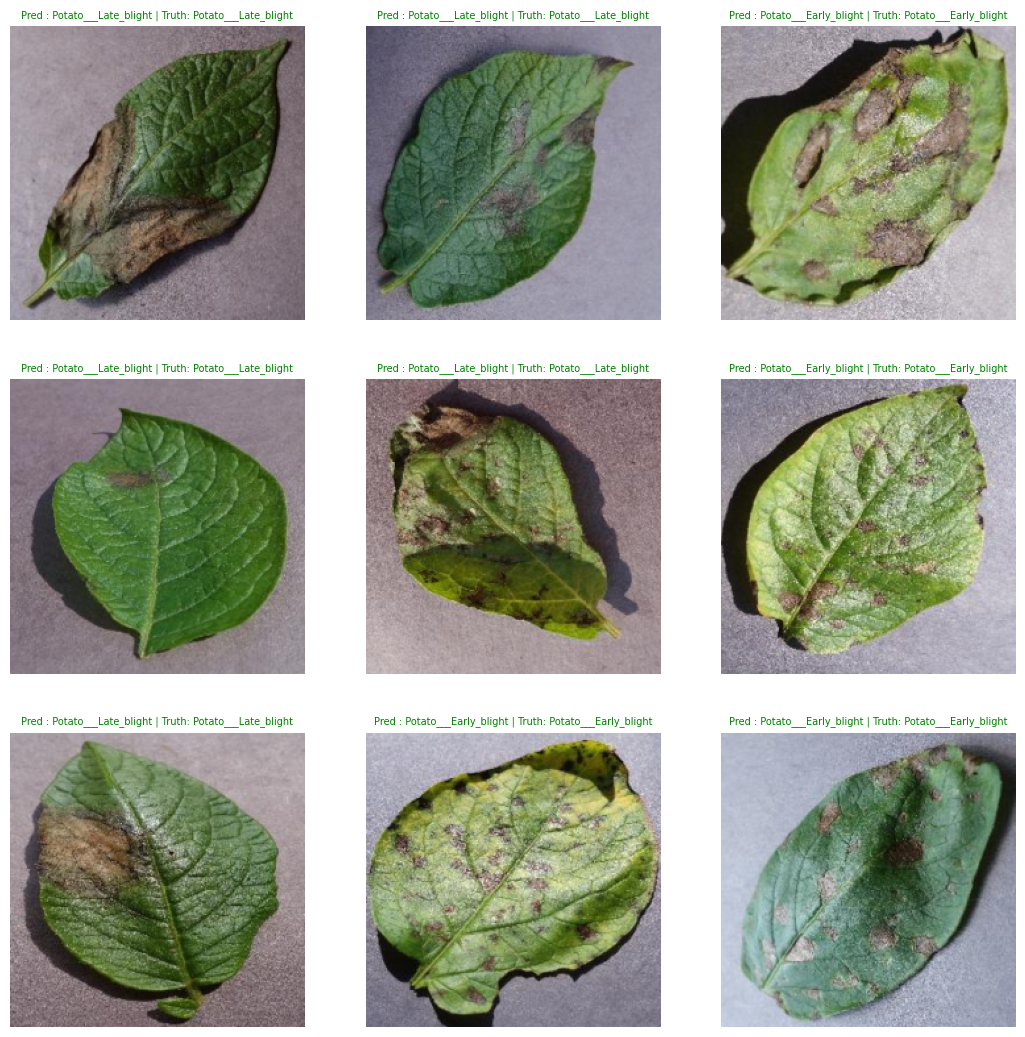

In [49]:
# Get a batch of images from the train_loader
images, labels = next(iter(test_dl))

with torch.no_grad():
  predicted_labels = model(images)
  predicted_labels = torch.argmax(predicted_labels, 1)
rows = col = 3
#fig, axes = plt.subplots(nrows=5, ncols=5)
plt.figure(figsize = (13,13))

for i in range(rows*col):
  # Plot a random image from the batch
  random_index = np.random.randint(0, images.shape[0])
  image = images[random_index]
  label = labels[random_index]
  pred_label = predicted_labels[random_index]
  plt.subplot(rows, col, i+1)
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))
  title_text = f"Pred : {dataset.classes[pred_label]} | Truth: {dataset.classes[label]}"
  if pred_label == label:
    plt.title(title_text, fontsize=7, c="g")
  else:
    plt.title(title_text, fontsize=7, c="r")
  plt.axis(False)

#Saving

Now Saving the model parameters...

In [50]:
torch.save(model.state_dict(), 'potato-disease-classification.pth')